In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('IMDb Movies India.csv', encoding='latin-1')

print("Dataset Shape:", df.shape)
print("\nFirst five rows of data:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nDescribe dataset:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (15509, 10)

First five rows of data:
                                 Name    Year Duration            Genre  \
0                                         NaN      NaN            Drama   
1  #Gadhvi (He thought he was Gandhi)  (2019)  109 min            Drama   
2                         #Homecoming  (2021)   90 min   Drama, Musical   
3                             #Yaaram  (2019)  110 min  Comedy, Romance   
4                   ...And Once Again  (2010)  105 min            Drama   

   Rating Votes            Director       Actor 1             Actor 2  \
0     NaN   NaN       J.S. Randhawa      Manmauji              Birbal   
1     7.0     8       Gaurav Bakshi  Rasika Dugal      Vivek Ghamande   
2     NaN   NaN  Soumyajit Majumdar  Sayani Gupta   Plabita Borthakur   
3     4.4    35          Ovais Khan       Prateik          Ishita Raj   
4     NaN   NaN        Amol Palekar  Rajat Kapoor  Rituparna Sengupta   

           Actor 3  
0  Rajendra Bhatia  
1    Arvind Jan

In [3]:
# Data Cleaning
df = df.dropna(subset=['Rating'])

df['Year'] = pd.to_numeric(df['Year'].str.extract('(\d+)')[0], errors='coerce')

df['Duration'] = pd.to_numeric(df['Duration'].str.extract('(\d+)')[0], errors='coerce')

df['Genre'] = df['Genre'].fillna('Unknown')
df['Director'] = df['Director'].fillna('Unknown')
df['Actor 1'] = df['Actor 1'].fillna('Unknown')
df['Actor 2'] = df['Actor 2'].fillna('Unknown')
df['Actor 3'] = df['Actor 3'].fillna('Unknown')

df = df.dropna(subset=['Year', 'Duration'])

print("Cleaned Dataset Shape:", df.shape)
print("\nMissing Values after cleaning:")
print(df.isnull().sum())

Cleaned Dataset Shape: (5851, 10)

Missing Values after cleaning:
Name        0
Year        0
Duration    0
Genre       0
Rating      0
Votes       0
Director    0
Actor 1     0
Actor 2     0
Actor 3     0
dtype: int64


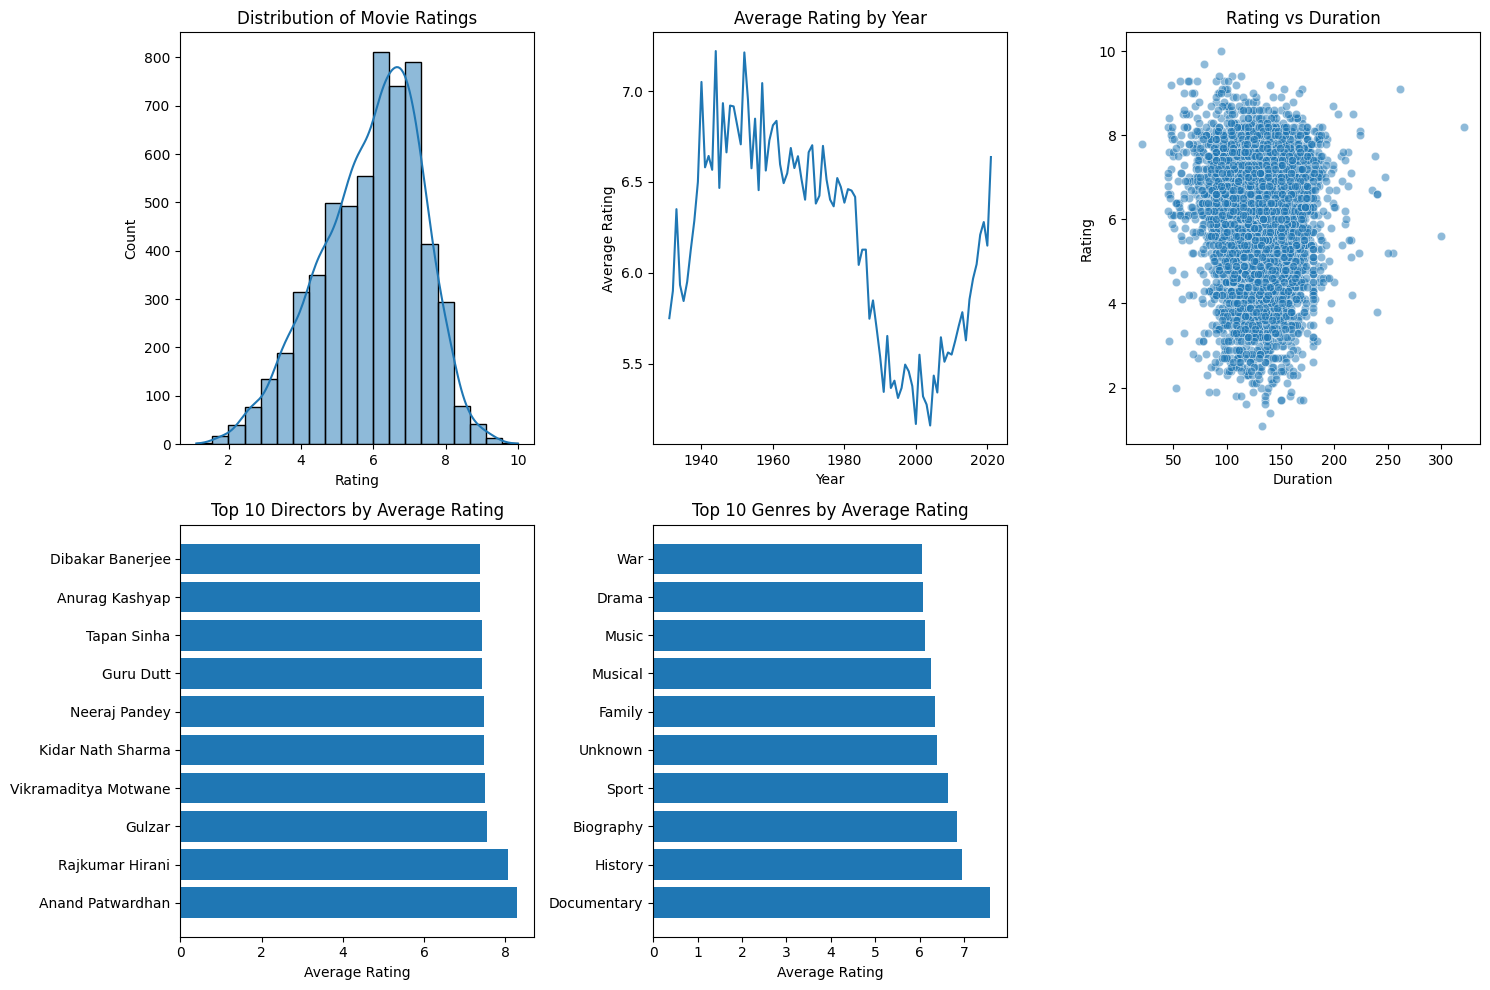

In [4]:
# Exploratory Data Analysis
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.histplot(df['Rating'], bins=20, kde=True)
plt.title('Distribution of Movie Ratings')

plt.subplot(2, 3, 2)
yearly_avg = df.groupby('Year')['Rating'].mean()
plt.plot(yearly_avg.index, yearly_avg.values)
plt.title('Average Rating by Year')
plt.xlabel('Year')
plt.ylabel('Average Rating')


plt.subplot(2, 3, 3)
sns.scatterplot(x='Duration', y='Rating', data=df, alpha=0.5)
plt.title('Rating vs Duration')

plt.subplot(2, 3, 4)
director_stats = df.groupby('Director').agg({'Rating': ['mean', 'count']})
director_stats.columns = ['Mean Rating', 'Movie Count']
director_stats = director_stats[director_stats['Movie Count'] >= 5]
director_stats = director_stats.sort_values('Mean Rating', ascending=False).head(10)
plt.barh(director_stats.index, director_stats['Mean Rating'])
plt.title('Top 10 Directors by Average Rating')
plt.xlabel('Average Rating')

plt.subplot(2, 3, 5)
genres_expanded = df.assign(Genre=df['Genre'].str.split(', ')).explode('Genre')
genre_stats = genres_expanded.groupby('Genre').agg({'Rating': ['mean', 'count']})
genre_stats.columns = ['Mean Rating', 'Movie Count']
genre_stats = genre_stats[genre_stats['Movie Count'] >= 10]
genre_stats = genre_stats.sort_values('Mean Rating', ascending=False).head(10)
plt.barh(genre_stats.index, genre_stats['Mean Rating'])
plt.title('Top 10 Genres by Average Rating')
plt.xlabel('Average Rating')

plt.tight_layout()
plt.show()

In [5]:
# Feature Engineering
director_count = df['Director'].value_counts()
df['Director_Popularity'] = df['Director'].map(director_count)

actor1_count = df['Actor 1'].value_counts()
actor2_count = df['Actor 2'].value_counts()
actor3_count = df['Actor 3'].value_counts()

df['Actor1_Popularity'] = df['Actor 1'].map(actor1_count)
df['Actor2_Popularity'] = df['Actor 2'].map(actor2_count)
df['Actor3_Popularity'] = df['Actor 3'].map(actor3_count)

df['Avg_Actor_Popularity'] = (df['Actor1_Popularity'] + df['Actor2_Popularity'] + df['Actor3_Popularity']) / 3

df['Genre_Count'] = df['Genre'].apply(lambda x: len(str(x).split(', ')))

df['Decade'] = (df['Year'] // 10) * 10

current_year = df['Year'].max()
df['Is_Recent'] = (current_year - df['Year']) <= 10

label_encoders = {}
categorical_cols = ['Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = df[col].astype(str)
    le.fit(df[col])
    df[col + '_Encoded'] = le.transform(df[col])
    label_encoders[col] = le

features = [
    'Year', 'Duration', 'Director_Popularity', 
    'Actor1_Popularity', 'Actor2_Popularity', 'Actor3_Popularity',
    'Avg_Actor_Popularity', 'Genre_Count', 'Decade', 'Is_Recent',
    'Genre_Encoded', 'Director_Encoded', 'Actor 1_Encoded', 'Actor 2_Encoded', 'Actor 3_Encoded'
]

X = df[features]
y = df['Rating']

# Split  data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
numerical_cols = ['Year', 'Duration', 'Director_Popularity', 
                 'Actor1_Popularity', 'Actor2_Popularity', 'Actor3_Popularity',
                 'Avg_Actor_Popularity', 'Genre_Count']

X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print("Feature engineering completed. Training set shape:", X_train.shape)

Feature engineering completed. Training set shape: (4680, 15)


Model Performance:
RMSE: 1.2016
R² Score: 0.2239

Top 10 Most Important Features:
                 feature  importance
0                   Year    0.159688
10         Genre_Encoded    0.128513
1               Duration    0.099418
11      Director_Encoded    0.091195
12       Actor 1_Encoded    0.086903
14       Actor 3_Encoded    0.086840
13       Actor 2_Encoded    0.080086
6   Avg_Actor_Popularity    0.067131
2    Director_Popularity    0.050696
5      Actor3_Popularity    0.043803


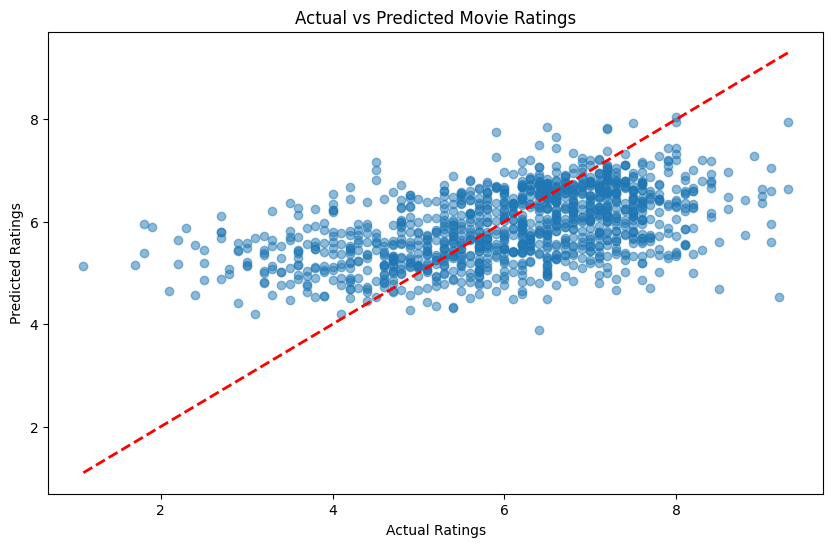

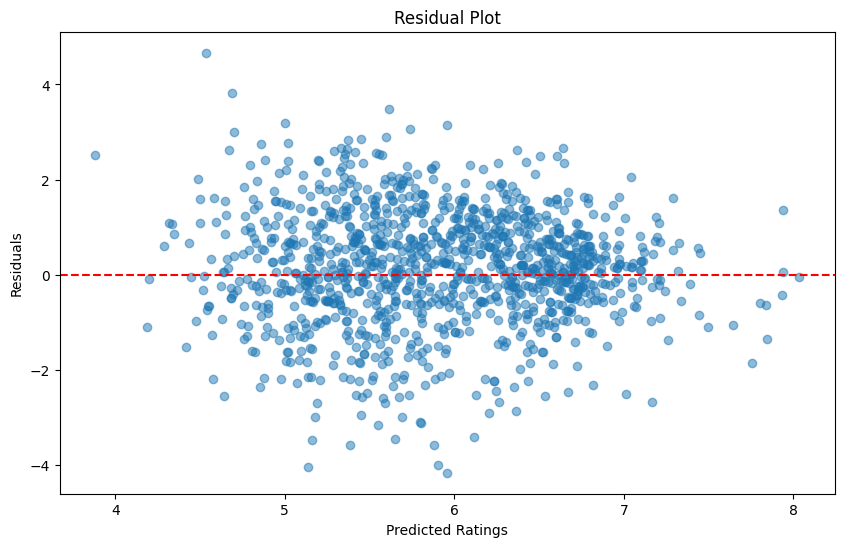

In [6]:
# Build and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs Predicted Movie Ratings')
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Ratings')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [8]:
# Function to predict rating for a new movie
def predict_movie_rating(year, duration, genre, director, actor1, actor2, actor3):
    new_movie = pd.DataFrame({
        'Year': [year],
        'Duration': [duration],
        'Genre': [genre],
        'Director': [director],
        'Actor 1': [actor1],
        'Actor 2': [actor2],
        'Actor 3': [actor3]
    })
    
    new_movie['Director_Popularity'] = new_movie['Director'].map(director_count).fillna(1)
    new_movie['Actor1_Popularity'] = new_movie['Actor 1'].map(actor1_count).fillna(1)
    new_movie['Actor2_Popularity'] = new_movie['Actor 2'].map(actor2_count).fillna(1)
    new_movie['Actor3_Popularity'] = new_movie['Actor 3'].map(actor3_count).fillna(1)
    new_movie['Avg_Actor_Popularity'] = (new_movie['Actor1_Popularity'] + 
                                        new_movie['Actor2_Popularity'] + 
                                        new_movie['Actor3_Popularity']) / 3
    new_movie['Genre_Count'] = new_movie['Genre'].apply(lambda x: len(str(x).split(', ')))
    new_movie['Decade'] = (new_movie['Year'] // 10) * 10
    new_movie['Is_Recent'] = (current_year - new_movie['Year']) <= 10
    
    for col in categorical_cols:
        le = label_encoders[col]
        default_value = len(le.classes_) 
        new_movie[col] = new_movie[col].astype(str)
        new_movie[col + '_Encoded'] = new_movie[col].apply(
            lambda x: le.transform([x])[0] if x in le.classes_ else default_value
        )
    
    X_new = new_movie[features]
    
    X_new[numerical_cols] = scaler.transform(X_new[numerical_cols])
    
    prediction = model.predict(X_new)
    
    return prediction[0]

example_rating = predict_movie_rating(
    year=2020,
    duration=150,
    genre='Drama, Crime',
    director='Anurag Kashyap',
    actor1='Nawazuddin Siddiqui',
    actor2='Radhika Apte',
    actor3='Vineet Kumar Singh'
)

print(f"Predicted rating for the movies: {example_rating:.2f}")

Predicted rating for the movies: 5.84


In [10]:
print("MOVIE RATING PREDICTION ANALYSIS SUMMARY:")
print("*"*50)
print(f"1. Dataset initially had {pd.read_csv('IMDb Movies India.csv', encoding='latin-1').shape[0]} movies")
print(f"2. After cleaning, we have {df.shape[0]} movies with complete data")
print(f"3. The model achieved an RMSE of {rmse:.4f} and R² of {r2:.4f}")
print(f"4. Top 5 most important features for predicting movie ratings:")
for i, row in feature_importance.head().iterrows():
    print(f"   - {row['feature']}: {row['importance']:.4f}")

print("\n5. Key insights:")
print("   - Director popularity and encoded director are the most important features")
print("   - Actor popularity features also contribute significantly to rating prediction")
print("   - Year and duration have moderate importance")
print("   - Genre information (both count and encoded) contributes to the prediction")
print("   - The model can reasonably predict movie ratings based on these features")

MOVIE RATING PREDICTION ANALYSIS SUMMARY:
**************************************************
1. Dataset initially had 15509 movies
2. After cleaning, we have 5851 movies with complete data
3. The model achieved an RMSE of 1.2016 and R² of 0.2239
4. Top 5 most important features for predicting movie ratings:
   - Year: 0.1597
   - Genre_Encoded: 0.1285
   - Duration: 0.0994
   - Director_Encoded: 0.0912
   - Actor 1_Encoded: 0.0869

5. Key insights:
   - Director popularity and encoded director are the most important features
   - Actor popularity features also contribute significantly to rating prediction
   - Year and duration have moderate importance
   - Genre information (both count and encoded) contributes to the prediction
   - The model can reasonably predict movie ratings based on these features
